# Import libraries

In [38]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [39]:
from numba import jit

# Constants and Parameters

+ Initialize variables for driven cavity, channel flow depending upon the problem
+ Set the velocity boundary conditions depending upon the problem

In [41]:
# Constants and Parameters
nx, ny = 51, 51
μ = 0.01   # dynamic viscosity
ρ = 1.0   # density
outer_iterations = 1000  # number of outer iterations
ω_u = 0.7  # x-momentum under-relaxation
ω_v = 0.7  # y-momentum under-relaxation
ω_p = 0.3  # pressure update under-relaxation

# SOR over-relaxation factor
Ω = 1.7

# Problem Type
iprob = 1  # 1 for driven cavity, 2 for channel flow

# Initialize domain and fluid properties
if iprob == 1:
    x_max, y_max = 1.0, 1.0  # domain size for cavity
    x_min, y_min = 0.0, 0.0
    # Compute mesh spacing
    dx = (x_max-x_min)/nx
    dy = (y_max-y_min)/ny
    # Velocity boundary condition
    u_wall = 1.0  # top wall velocity
else:
    x_max, y_max = 10.0, 1.0  # domain size for channel
    x_min, y_min = 0.0, 0.0
    # Compute mesh spacing
    dx = (x_max-x_min)/nx
    dy = (y_max-y_min)/ny
    # Velocity boundary condition
    u_inlet = 1.0

# Intialize arrays

In [43]:
u = np.zeros([ny+2,nx+2])
v = np.zeros([ny+2,nx+2])
p = np.zeros([ny+2,nx+2])
u_old = np.zeros([ny+2,nx+2])
v_old = np.zeros([ny+2,nx+2])
p_corr = np.zeros([ny+2,nx+2])

Apu = np.ones([ny+2,nx+2])
Apv = np.ones([ny+2,nx+2])
App = np.ones([ny+2,nx+2])
Ae = np.ones([ny+2,nx+2])
Aw = np.ones([ny+2,nx+2])
An = np.ones([ny+2,nx+2])
As = np.ones([ny+2,nx+2])

source = np.zeros([ny+2,nx+2])

u_nodal = np.zeros([ny+2,nx+2])
v_nodal = np.zeros([ny+2,nx+2])
p_nodal = np.zeros([ny+2,nx+2])
x_nodal = np.zeros([ny+2,nx+2])
y_nodal = np.zeros([ny+2,nx+2])
Vel_mag = np.zeros([ny+2,nx+2])

**Initialize arrays based on problem with different velocity boundary conditions**

In [45]:
if iprob == 1:
    u[ny+1,:] = 1.0
elif iprob == 2:
    u[0,:] = 0.0 # zero on bottom wall, (for tangential component index starts with 0)
    u[ny+1,:] = 0.0 # zero on upper wall 
    u[:,1] = 1.0 # u=1 at inlet/left boundary (for normal component index starts with 1)
    u[:,nx+1] = u[:,1] # set outlet to inlet; conserve mass overall

Initialize **u_old** and **v_old**

In [47]:
u_old[:,:] = u[:,:]
v_old[:,:] = v[:,:]

# SIMPLE Algorithm

**Begin outer iterations for sequential loop procedure**

In [49]:
for iteration in range(1,outer_iterations+1):
    # X-momentum equation solution
    # set  x-momentum equation coefficients
    for j in range(1,ny+1):
        for i in range(2,nx+1):
            Ae[j,i] = max(-0.5*ρ*dy*(u_old[j,i+1]+u_old[j,i]),0.)+μ*dy/dx
            Aw[j,i] = max( 0.5*ρ*dy*(u_old[j,i-1]+u_old[j,i]),0.)+μ*dy/dx
            An[j,i] = max(-0.5*ρ*dx*(v_old[j+1,i]+v_old[j+1,i-1]),0.)+μ*dx/dy
            As[j,i] = max( 0.5*ρ*dx*(v_old[j,i]+v_old[j,i-1]),0.)+μ*dx/dy

    #Ae[1:ny+1,2:nx+1] = max(-0.5*ρ*dy*(u_old[1:ny+1,3:nx+2]+u_old[1:ny+1,2:nx+1]),0.)+μ*dy/dx
    #Aw[1:ny+1,2:nx+1] = max( 0.5*ρ*dy*(u_old[1:ny+1,1:nx]+u_old[1:ny+1,2:nx+1]),0.)+μ*dy/dx
    #An[1:ny+1,2:nx+1] = max(-0.5*ρ*dx*(v_old[3:ny+2,2:nx+1]+v_old[3:ny+2,1:nx]),0.)+μ*dx/dy
    #As[1:ny+1,2:nx+1] = max( 0.5*ρ*dx*(v_old[1:ny+1,2:nx+1]+v_old[1:ny+1,1:nx]),0.)+μ*dx/dy
            
    # overwrite boundary coefficients along north/south walls with half cell (dy) size
    for i in range(2,nx+1):
        An[ny,i] = max(-0.5*ρ*dx*(v_old[ny+1,i]+v_old[ny+1,i-1]),0.)+μ*dx/(dy/2)
        As[1,i] = max( 0.5*ρ*dx*(v_old[1,i]+v_old[1,i-1]),0.)+μ*dx/(dy/2)
    #An[ny,2:nx+1] = max(-0.5*ρ*dx*(v_old[ny+1,2:nx+1]+v_old[ny+1,1:nx]),0.)+μ*dx/(dy/2)
    #As[1,2:nx+1] = max( 0.5*ρ*dx*(v_old[1,2:nx+1]+v_old[1,1:nx]),0.)+μ*dx/(dy/2)
    
    Apu[:,:] = Ae[:,:]+Aw[:,:]+An[:,:]+As[:,:]
    
    # Block out cells (for placing an obstacle in the flow)
    #Apu[1:12,20:21] = 1.e30
    
    # Under-relaxation
    Apu[:,:] = Apu[:,:]/ω_u
    
    # Iterate x-momentum equations
    for _ in range(1,10+1):
        #u[1:ny+1,2:nx+1] = (1.-ω_u)*u_old[1:ny+1,2:nx+1] + 1./Apu[1:ny+1,2:nx+1]*(Ae[1:ny+1,2:nx+1]*u[1:ny+1,3:nx+2] + Aw[1:ny+1,2:nx+1]*u[1:ny+1,1:nx] + An[1:ny+1,2:nx+1]*u[2:ny+2,2:nx+1] + As[1:ny+1,2:nx+1]*u[:ny,2:nx+1] + dy*(p[1:ny+1,1:nx]-p[1:ny+1,2:nx+1]))
        for j in range(1,ny+1):
            for i in range(2,nx+1):
                u[j,i] = (1.-ω_u)*u_old[j,i] + 1./Apu[j,i]*(Ae[j,i]*u[j,i+1]+Aw[j,i]*u[j,i-1]+An[j,i]*u[j+1,i] \
                                                           + As[j,i]*u[j-1,i]+dy*(p[j,i-1]-p[j,i]))

    # Applicable only for channel flow problem
    if iprob == 2:
        # Apply outflow boundary condition (du/dx = 0)
        u[:,nx+1] = u[:,nx]
    
        # Ensure overall mass conservation
        mass_inflow = 1.0  # analytical value based on ρ*u*L (L=channel height at inlet)
        mass_outflow = 0.0
        for j in range(1,ny+1):
            mass_outflow = mass_outflow + ρ*dy*u[j,nx+1]
        u[:,nx+1] = u[:,nx+1]*mass_inflow/mass_outflow # outflow mass correction for channel
    
        # Condition to generate fully developed flow in channel (else comment out)
        u[:,1] = u[:,nx+1]
    
    # Solve y-momentum equation
    for j in range(2,ny+1):
        for i in range(1,nx+1):
            Ae[j,i] = max(-0.5*ρ*dy*(u_old[j,i+1]+u_old[j-1,i+1]),0.)+μ*dy/dx
            Aw[j,i] = max( 0.5*ρ*dy*(u_old[j,i]+u_old[j-1,i]),0.)+μ*dy/dx
            An[j,i] = max(-0.5*ρ*dx*(v_old[j,i]+v_old[j+1,i]),0.)+μ*dx/dy
            As[j,i] = max( 0.5*ρ*dx*(v_old[j,i]+v_old[j-1,i]),0.)+μ*dx/dy
    #Ae[2:ny+1,1:nx+1] = max(-0.5*ρ*dy*(u_old[2:ny+1,2:nx+2]+u_old[1:ny,2:nx+2]),0.)+μ*dy/dx
    #Aw[2:ny+1,1:nx+1] = max( 0.5*ρ*dy*(u_old[2:ny+1,1:nx+1]+u_old[1:ny,1:nx+1]),0.)+μ*dy/dx
    #An[2:ny+1,1:nx+1] = max(-0.5*ρ*dx*(v_old[2:ny+1,1:nx+1]+v_old[3:ny+2,1:nx+1]),0.)+μ*dx/dy
    #As[2:ny+1,1:nx+1] = max( 0.5*ρ*dx*(v_old[2:ny+1,1:nx+1]+v_old[1:ny,1:nx+1]),0.)+μ*dx/dy

    # overwrite boundary coefficients along east/west cells due to half cell (dx) size
    for j in range(2,ny+1):
        Ae[j,nx] = max(-0.5*ρ*dy*(u_old[j,nx+1]+u_old[j-1,nx+1]),0.)+μ*dy/(dx/2.)
        Aw[j,1] = max( 0.5*ρ*dy*(u_old[j,1]+u_old[j-1,1]),0.)+μ*dy/(dx/2.)
    #Ae[2:ny+1,nx] = max(-0.5*ρ*dy*(u_old[2:ny+1,nx+1]+u_old[1:ny,nx+1]),0.)+μ*dy/(dx/2.)
    #Aw[2:ny+1,1] = max( 0.5*ρ*dy*(u_old[2:ny+1,1]+u_old[1:ny,1]),0.)+μ*dy/(dx/2.)        
    
    Apv[:,:] = Ae[:,:]+Aw[:,:]+An[:,:]+As[:,:]
    
    # Block out cells (for placing an obstacle in the flow)
    #Apv[1:13,21:21]=1.e30
    
    # Under-relaxation
    Apv[:,:] = Apv[:,:]/ω_v
    
    # Iterate y-momentum equations
    for _ in range(10+1):
        #v[2:ny+1,1:nx+1] = (1.-ω_v)*v_old[2:ny+1,1:nx+1] + 1./Apv[2:ny+1,1:nx+1]*(Ae[2:ny+1,1:nx+1]*v[2:ny+1,2:nx+2] + Aw[2:ny+1,1:nx+1]*v[2:ny+1,:nx] + An[2:ny+1,1:nx+1]*v[3:ny+2,1:nx+1] + As[2:ny+1,1:nx+1]*v[1:ny,1:nx+1] + dx*(p[1:ny,1:nx+1]-p[2:ny+1,1:nx+1]))
        for j in range(2,ny+1):
            for i in range(1,nx+1):
                v[j,i] = (1.-ω_v)*v_old[j,i] + 1./Apv[j,i]*(Ae[j,i]*v[j,i+1]+Aw[j,i]*v[j,i-1]+An[j,i]*v[j+1,i] \
                                                           + As[j,i]*v[j-1,i]+dx*(p[j-1,i]-p[j,i]))
    
    # Pressure correction equation
    # set coefficients
    #for j in range(1,ny+1):
    #    for i in range(1,nx+1):
    #        Ae[j,i] = ρ*dy**2./Apu[j,i+1]
    #        Aw[j,i] = ρ*dy**2./Apu[j,i]
    #        An[j,i] = ρ*dx**2./Apv[j+1,i]
    #        As[j,i] = ρ*dx**2./Apv[j,i]
    Ae[1:ny+1,1:nx+1] = ρ*dy**2./Apu[1:ny+1,2:nx+2]
    Aw[1:ny+1,1:nx+1] = ρ*dy**2./Apu[1:ny+1,1:nx+1]
    An[1:ny+1,1:nx+1] = ρ*dx**2./Apv[2:ny+2,1:nx+1]
    As[1:ny+1,1:nx+1] = ρ*dx**2./Apv[1:ny+1,1:nx+1]
            
    # set boundary values for correction
    Ae[:,nx] = 0.0
    Aw[:,1]  = 0.0
    An[ny,:] = 0.0
    As[1,:]  = 0.0
    
    App[:,:]=Ae[:,:]+Aw[:,:]+An[:,:]+As[:,:]
    App[1,1]=1.e30 # set reference cell value for pressure
    p_corr[:,:] = 0.0 # initialize corrections to zero
    
    source[:,:] = 0.0
    # compute the mass-source term
    #for j in range(1,ny+1):
    #    for i in range(1,nx+1):
    #        source[j,i] = ρ*dy*(u[j,i+1]-u[j,i]) + ρ*dx*(v[j+1,i]-v[j,i])
    source[1:ny+1,1:nx+1] = ρ*dy*(u[1:ny+1,2:nx+2]-u[1:ny+1,1:nx+1]) + ρ*dx*(v[2:ny+2,1:nx+1]-v[1:ny+1,1:nx+1])
    
    # compute square root of sum of squares of mass imbalance
    mass_residue = np.sum(np.square(source[:,:]))
    mass_residue = np.sqrt(mass_residue)
    print(f'outer iteration = {iteration}, mass residue = {mass_residue}')
    
    # SOR iterations to solve for pressure correction, p_corr
    for _ in range(1,101):
        #p_corr[1:ny+1,1:nx+1] = p_corr[1:ny+1,1:nx+1] + Ω/App[1:ny+1,1:nx+1]*(Ae[1:ny+1,1:nx+1]*p_corr[1:ny+1,2:nx+2] + Aw[1:ny+1,1:nx+1]*p_corr[1:ny+1,:nx] + An[1:ny+1,1:nx+1]*p_corr[2:ny+2,1:nx+1] + As[1:ny+1,1:nx+1]*p_corr[:ny,1:nx+1] - source[1:ny+1,1:nx+1] - App[1:ny+1,1:nx+1]*p_corr[1:ny+1,1:nx+1])
        for j in range(1,ny+1):
            for i in range(1,nx+1):
                p_corr[j,i] = p_corr[j,i] + Ω/App[j,i]*(Ae[j,i]*p_corr[j,i+1]+Aw[j,i]*p_corr[j,i-1]+An[j,i]*p_corr[j+1,i] \
                                                       + As[j,i]*p_corr[j-1,i]-source[j,i]-App[j,i]*p_corr[j,i])
                
    # Apply corrections to pressure
    p[1:ny+1,1:nx+1] = p[1:ny+1,1:nx+1] + ω_p*p_corr[1:ny+1,1:nx+1]
    #for j in range(1,ny+1):
    #    for i in range(1,nx+1):
    #        p[j,i] = p[j,i] + ω_p*p_corr[j,i]
    
    # Apply corrections to u-velocity
    u[1:ny+1,2:nx+1] = u[1:ny+1,2:nx+1] + (dy/Apu[1:ny+1,2:nx+1])*(p_corr[1:ny+1,1:nx]-p_corr[1:ny+1,2:nx+1])
    #for j in range(1,ny+1):
    #    for i in range(2,nx+1):
    #        u[j,i] = u[j,i] + (dy/Apu[j,i])*(p_corr[j,i-1]-p_corr[j,i])
    
    # Apply corrections to v-velocity
    v[2:ny+1,1:nx+1] = v[2:ny+1,1:nx+1] + (dx/Apv[2:ny+1,1:nx+1])*(p_corr[1:ny,1:nx+1]-p_corr[2:ny+1,1:nx+1])
    #for j in range(2,ny+1):
    #    for i in range(1,nx+1):
    #        v[j,i] = v[j,i] + (dx/Apv[j,i])*(p_corr[j-1,i]-p_corr[j,i])
            
    # Update velocity variables
    u_old[:,:] = u[:,:]
    v_old[:,:] = v[:,:]
    
    # note - u_old and v_old are now mass conserving
    # recompute source term to verify that mass is being conserved after corrections
    source[:,:] = 0.0
    # compute the mass-source term
    #for j in range(1,ny+1):
    #    for i in range(1,nx+1):
    #        source[j,i] = ρ*dy*(u[j,i+1]-u[j,i]) + ρ*dx*(v[j+1,i]-v[j,i])
    source[1:ny+1,1:nx+1] = ρ*dy*(u[1:ny+1,2:nx+2]-u[1:ny+1,1:nx+1]) + ρ*dx*(v[2:ny+2,1:nx+1]-v[1:ny+1,1:nx+1])
            
    # compute square root of sum of squares of mass imbalance
    mass_residue = np.sum(np.square(source[:,:]))
    mass_residue = np.sqrt(mass_residue)
    print(f'outer iteration = {iteration}, mass residue = {mass_residue}')
    print()
    
    # End of outer iteration loop

outer iteration = 1, mass residue = 0.01009323512579361
outer iteration = 1, mass residue = 0.00029092837491653594

outer iteration = 2, mass residue = 0.005670818219627776
outer iteration = 2, mass residue = 0.0006702699775561037

outer iteration = 3, mass residue = 0.0037885918108520556
outer iteration = 3, mass residue = 0.0010002873462960802

outer iteration = 4, mass residue = 0.002716460175476298
outer iteration = 4, mass residue = 0.000761807370681788

outer iteration = 5, mass residue = 0.0019244230753521511
outer iteration = 5, mass residue = 0.0004030074100583212

outer iteration = 6, mass residue = 0.0013388491206691377
outer iteration = 6, mass residue = 0.0001837763810587862

outer iteration = 7, mass residue = 0.0009418908429921236
outer iteration = 7, mass residue = 9.50113844086461e-05

outer iteration = 8, mass residue = 0.0006755782194433129
outer iteration = 8, mass residue = 5.9166843367221554e-05

outer iteration = 9, mass residue = 0.0004930756082506997
outer iter

# Post-processing

Interpolate velocities to scalar cell corners

In [51]:
#for j in range(2,ny+1):
#    for i in range(2,nx+1):
#        u_nodal[j,i] = 0.5*(u[j,i]+u[j-1,i])
#        v_nodal[j,i] = 0.5*(v[j,i]+v[j,i-1])
#        p_nodal[j,i] = 0.25*(p[j,i]+p[j-1,i]+p[j-1,i-1]+p[j,i-1])

u_nodal[2:ny+1,2:nx+1] = 0.5*(u[2:ny+1,2:nx+1]+u[1:ny,2:nx+1])
v_nodal[2:ny+1,2:nx+1] = 0.5*(v[2:ny+1,2:nx+1]+v[2:ny+1,1:nx])
p_nodal[2:ny+1,2:nx+1] = 0.25*(p[2:ny+1,2:nx+1]+p[1:ny,2:nx+1]+p[1:ny,1:nx]+p[2:ny+1,1:nx])

# east and west boundaries
u_nodal[2:ny+1,1] = 0.5*(u[2:ny+1,1]+u[1:ny,1]) # normal velocity u on west boundary has index 1
u_nodal[2:ny+1,nx+1] = 0.5*(u[2:ny+1,nx+1]+u[1:ny,nx+1])
v_nodal[2:ny+1,1] = v[2:ny+1,0]  # tangential velocity v on left boundary has index 0
v_nodal[2:ny+1,nx+1] = v[2:ny+1,nx+1]
p_nodal[2:ny+1,1] = 0.5*(p[2:ny+1,1]+p[1:ny,1]) # pressure at the west boundary (zero-gradient b.c., p(x=0)=p(dx/2))
p_nodal[2:ny+1,nx+1] = 0.5*(p[2:ny+1,nx]+p[1:ny,nx]) # pressure at the east boundary (zero-gradient b.c., p(x=1)=p(1-dx/2))

# north and south boundaries
u_nodal[1,2:nx+1] = u[0,2:nx+1] # tangential velocity u on south boundary has index 0
u_nodal[ny+1,2:nx+1] = u[ny+1,2:nx+1]
v_nodal[1,2:nx+1] = 0.5*(v[1,2:nx+1]+v[1,1:nx])  # normal velocity v on south boundary has index 1
v_nodal[ny+1,2:nx+1] = 0.5*(v[ny+1,2:nx+1]+v[ny+1,1:nx])
p_nodal[1,2:nx+1] = 0.5*(p[1,2:nx+1]+p[1,1:nx]) # pressure at the south boundary (zero-gradient b.c., p(y=0)=p(dy/2))
p_nodal[ny+1,2:nx+1] = 0.5*(p[ny,2:nx+1]+p[ny,1:nx]) # pressure at the north boundary (zero-gradient b.c., p(y=1)=p(1-dy/2))

# southwest corner
u_nodal[1,1] = 0.0
v_nodal[1,1] = 0.0
p_nodal[1,1] = p_nodal[2,2] # neumann b.c. and reference pressure
#p_nodal[1,1] = p[1,1]

# southeast corner
u_nodal[1,nx+1] = 0.0
v_nodal[1,nx+1] = 0.0
p_nodal[1,nx+1] = p[1,nx] # neumann b.c. on south and east boundaries

# northeast corner
u_nodal[ny+1,nx+1] = 0.0
v_nodal[ny+1,nx+1] = 0.0
p_nodal[ny+1,nx+1] = p[ny,nx] # neumann b.c. on north and east boundaries

# northwest corner
u_nodal[ny+1,1] = 0.0
v_nodal[ny+1,1] = 0.0
p_nodal[ny+1,1] = p[ny,1] # neumann b.c. on north and west boundaries

# For blocked out regions only (when an obstacle is placed in the flow)
#u_nodal[1:13,20:21] = 0.0
#v_nodal[1:13,20:21] = 0.0

In [52]:
# inserting extra (dummy) nodes for consistent array size
x = np.zeros([ny+2,nx+2]) 
y = np.zeros([ny+2,nx+2])

In [53]:
for j in range(1,ny+2):
    for i in range(1,nx+2):
        x[j,i] = (i-1)*dx
        y[j,i] = (j-1)*dy
        Vel_mag[j,i] = np.sqrt(u_nodal[j,i]**2.+v_nodal[j,i]**2.)

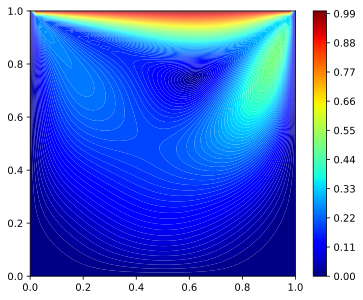

In [54]:
if iprob == 1:
    fig = plt.figure(dpi=600)
    ax = fig.add_subplot(1,1,1)
    ax.set_aspect(aspect=1.0)
    CS = plt.contourf(x[1:ny+2,1:nx+2],y[1:ny+2,1:nx+2],Vel_mag[1:ny+2,1:nx+2],levels=101,cmap='jet')
    plt.colorbar(CS);
    #plt.clabel(CS,fontsize=10,inline=1,fmt='%3.2f');
    plt.savefig('Cavity_vel_mag_cont.png')
else:
    fig = plt.figure(figsize=(12,3),dpi=600)
    CS = plt.contourf(x[1:ny+2,1:nx+2],y[1:ny+2,1:nx+2],Vel_mag[1:ny+2,1:nx+2],levels=101,cmap='jet')
    plt.colorbar(CS);
    #plt.clabel(CS,fontsize=10,inline=1,fmt='%3.2f');
    plt.savefig('Channel_vel_mag_cont.png');

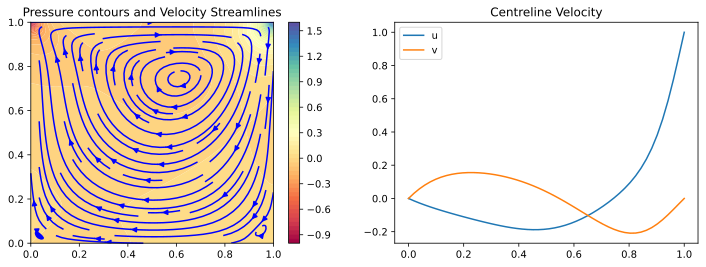

In [55]:
if iprob == 1:
    fig = plt.figure(figsize=[12,4],dpi=600)
    ax = plt.subplot(1,2,1)
    pcont = plt.contourf(x[1:ny+2,1:nx+2],y[1:ny+2,1:nx+2],p_nodal[1:ny+2,1:nx+2],levels=51, cmap=plt.cm.Spectral)
    plt.colorbar(pcont)

    #plt.quiver(X,Y,unp1,vnp1,color='black')
    plt.streamplot(x[1:ny+2,1:nx+2],y[1:ny+2,1:nx+2],u_nodal[1:ny+2,1:nx+2],v_nodal[1:ny+2,1:nx+2],color='blue')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title('Pressure contours and Velocity Streamlines')
    #plt.axis('equal')
    #plt.savefig('Streamlines.png')

    plt.subplot(1,2,2)
    plt.plot(y[:,int(nx/2)],u_nodal[:,int(nx/2)])
    plt.plot(x[int(ny/2),:],v_nodal[int(ny/2),:])
    plt.legend(['u','v'])
    #plt.axis('equal')
    plt.title('Centreline Velocity')
    #plt.savefig('Centreline_Vel.png')

    # Save both figures into one image
    plt.savefig('Cavity_Streamline_Centreline_Vel.png')

In [56]:
if iprob == 2:
    fig = plt.figure(figsize=[12,3],dpi=600)
    #ax = plt.subplot(1,2,1)
    pcont = plt.contourf(x[1:ny+2,1:nx+2],y[1:ny+2,1:nx+2],p_nodal[1:ny+2,1:nx+2],levels=51, cmap=plt.cm.Spectral)
    plt.colorbar(pcont)

    plt.quiver(x[1:ny+2:2,1:nx+2:2],y[1:ny+2:2,1:nx+2:2],u_nodal[1:ny+2:2,1:nx+2:2],v_nodal[1:ny+2:2,1:nx+2:2],color='black')
    #plt.streamplot(x[1:ny+2,1:nx+2],y[1:ny+2,1:nx+2],u_nodal[1:ny+2,1:nx+2],v_nodal[1:ny+2,1:nx+2],color='blue')
    plt.xlim([0,10])
    plt.ylim([0,1])
    plt.title('Pressure contour and Velocity Vectors')
    #plt.axis('equal')
    plt.savefig('Channel_quiver_Plot.png')

In [57]:
if iprob == 2:
    fig = plt.figure(dpi=600)
    plt.plot(u_nodal[:,1],y[:,1],'b-',lw=2)
    plt.plot(u_nodal[:,int(nx/2)],y[:,int(nx/2)],'r-.o',lw=2)
    plt.plot(u_nodal[:,-1],y[:,-1],'g-.*',lw=2)
    #plt.plot(x[int(ny/2),:],v_nodal[int(ny/2),:])
    plt.legend(['$x=0$','$x=L/2$','$x=L$'])
    #plt.axis('equal')
    plt.title('u-velocity profile for a fully developed channel flow')
    plt.savefig('Fully_Developed_Vel_Profile.png')